ADY201m

# Time series ARIMA Forecasting

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Step1: Import dataset

In [53]:
data_file = "BTC_USD-13-07-2010_27-02-2024.csv"
df = pd.read_csv(data_file,parse_dates= ['Date'],index_col=['Date'])

# Use only ['Close'] column
# Run only one time
df = df.iloc[:,[3]]
# Drop '2010-07' because it doesn't have enough 30(31) days
df = df.drop(df['Close']['2010-07'].index)
df.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_624\2410774239.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(data_file,parse_dates= ['Date'],index_col=['Date'])


,Close
Date,
2024-02-27,57085.372307
2024-02-26,54522.401537
2024-02-25,51733.236602
2024-02-24,51571.103112
2024-02-23,50731.949191


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4959 entries, 2024-02-27 to 2010-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4959 non-null   float64
dtypes: float64(1)
memory usage: 77.5 KB


<Axes: xlabel='Date'>

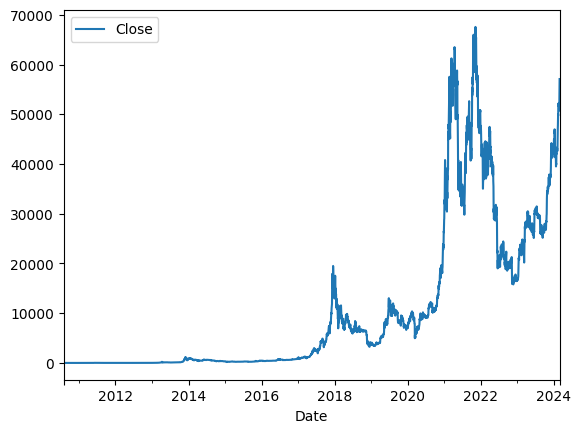

In [55]:
df.plot()

# Step 2: Resample data
By monthly (mean)

In [56]:
df = df['Close'].resample('MS').mean()
df

Date
2010-08-01        0.065722
2010-09-01        0.062465
2010-10-01        0.112031
2010-11-01        0.271386
2010-12-01        0.248209
                  ...     
2023-10-01    29755.895133
2023-11-01    36596.164921
2023-12-01    42546.893300
2024-01-01    42919.612244
2024-02-01    48988.032831
Freq: MS, Name: Close, Length: 163, dtype: float64

<Axes: xlabel='Date'>

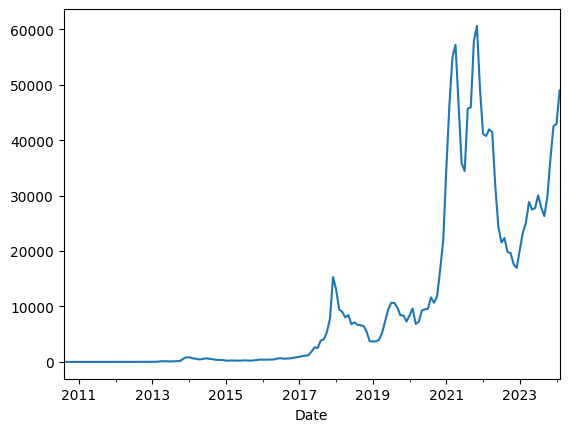

In [57]:
df.plot()

# Step 3: Stationarity check 

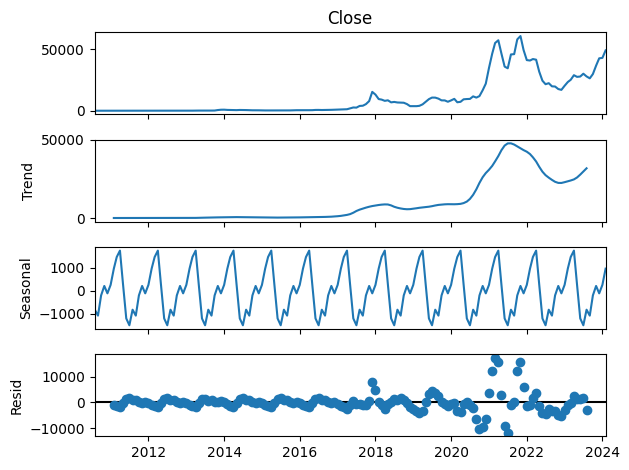

In [58]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df,model='additive')
fig = decomposition.plot()
plt.show()

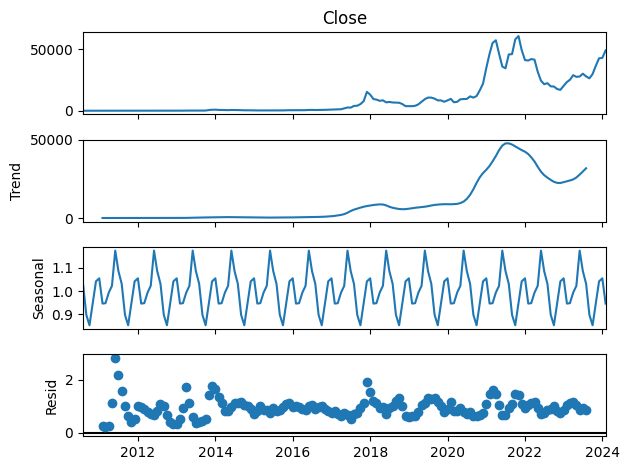

In [59]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df,model='multiplitive')
fig = decomposition.plot()
plt.show()

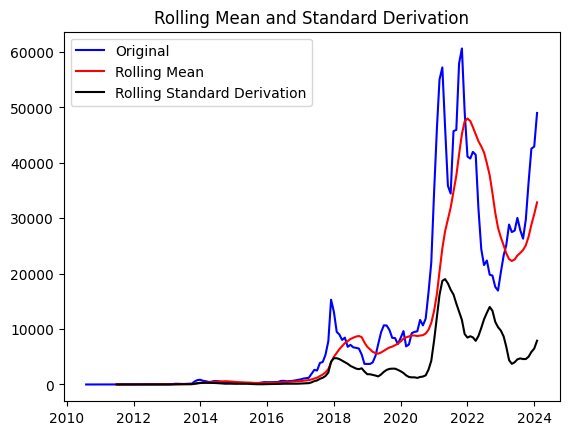

Result of ADF test:
The test statistic             -0.739603
p-value                         0.836223
#Lags used                      2.000000
The number of observations    160.000000
dtype: float64
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


In [60]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(data):
    """


    Plot rolling statistics
    and the result test whether stationarity or not

    """

    def dataset_plot(data=data):

        # Determine rolling statistics


        roll_mean = data.rolling(window=12).mean()


        roll_std = data.rolling(window=12).std()


        org = plt.plot(data, color="blue", label="Original")


        r_mean = plt.plot(roll_mean, color="red", label="Rolling Mean")


        r_std = plt.plot(roll_std, color="black", label="Rolling Standard Derivation")


        plt.legend(loc="best")

        plt.title("Rolling Mean and Standard Derivation")


        plt.show(block=False)

    def ADF_test(data=data):
        # Stationarity check by ADF

        print("Result of ADF test:")
        result = adfuller(data)

        index = [
            "The test statistic",
            "p-value",
            "#Lags used",
            "The number of observations",
        ]
        adf_output = pd.Series(result[:4], index=index)
        print(adf_output)
        print("Critical Values:")
        for key, value in result[4].items():
            print("\t%s: %.3f" % (key, value))

    dataset_plot(data)
    ADF_test(data)

test_stationarity(df)

Chúng ta cần sai phân để chuỗi dừng (stationarity)

# Step 3.1: Lấy sai phân 2 lần

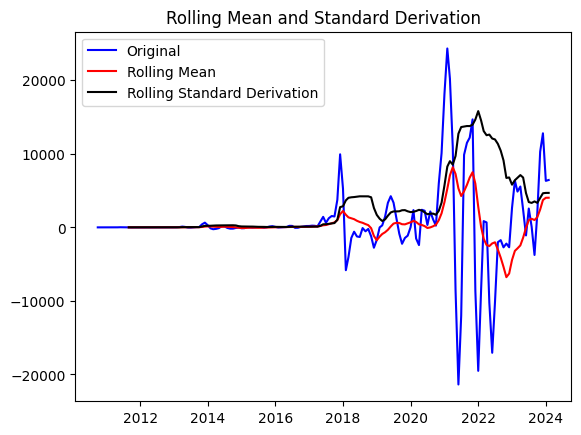

Result of ADF test:
The test statistic             -3.620080
p-value                         0.005389
#Lags used                     13.000000
The number of observations    147.000000
dtype: float64
Critical Values:
	1%: -3.476
	5%: -2.881
	10%: -2.577


In [63]:
df_d2 = df.diff(2)

df_d2.dropna(inplace=True)

test_stationarity(df_d2)

# Step 4: Train Test split: 90-10

161


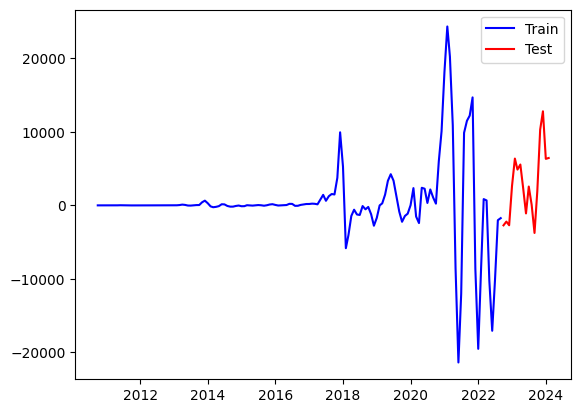

In [64]:
r_t = df_d2
print(len(r_t))
train = r_t[: int(0.9 * len(r_t))]
test = r_t[int(0.9 * len(r_t)) :]
plt.plot(train, color="b", label="Train")
plt.plot(test, color="r", label="Test")
plt.legend(loc="best")

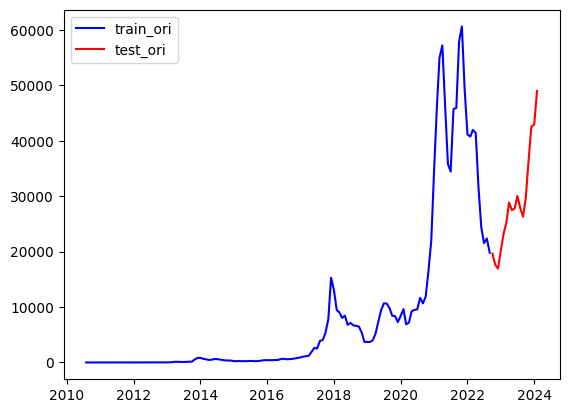

In [65]:
train_ori = df[: int(0.9 * len(df))]
test_ori = df[int(0.9 * len(df)) :]
plt.plot(train_ori, color="b", label="train_ori")
plt.plot(test_ori, color="r", label="test_ori")
plt.legend(loc="best")

View ACF, PACF of train data

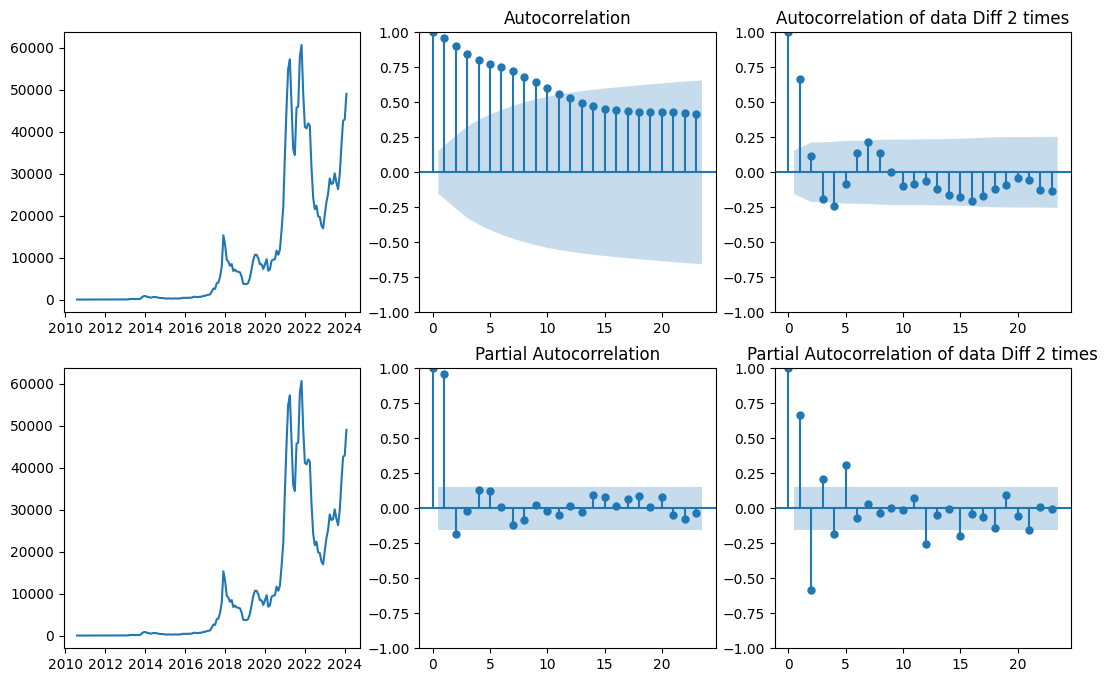

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(13, 8))

axes[0,0].plot(df)
plot_acf(df,ax=axes[0,1])
plot_acf(df_d2.dropna(),ax=axes[0,2],title='Autocorrelation of data Diff 2 times')

axes[1,0].plot(df)
plot_pacf(df,ax=axes[1,1])
plot_pacf(df_d2.dropna(),ax=axes[1,2],title='Partial Autocorrelation of data Diff 2 times')

plt.show()

--------------


# Step 5: Build model ARIMA

In [67]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Step 6: Choose parameters for ARIMA(p,d,q)
ARIMA has 3 components:
1. AR order p
2. MA order q
3. Intergrated order d

In [68]:
import itertools
p = q = range(0,6)
d = range(0,3)
pdq_combination = list(itertools.product(p,d,q))
# Size of pdq = 5x2x5 = 50
len(pdq_combination)

108

In [69]:
rmse = []
mae = []
order = []
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
for pdq in pdq_combination:
    try:
        model = ARIMA(train_ori,order = pdq).fit()
        # predict the test data: test: [len(train):len(df)]
        pred = model.predict(start = len(train_ori),end = len(df) - 1)
        square_error = np.sqrt(mean_squared_error(test_ori,pred))
        absolute_error = mean_absolute_error(test_ori,pred)
        order.append(pdq)
        rmse.append(square_error)
        mae.append(absolute_error)
    except:
        print('OUT')
        continue
results = pd.DataFrame(index=order,data = rmse,columns=['RMSE'])
results.head()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  

,RMSE
"(0, 0, 0)",22324.854088
"(0, 0, 1)",22507.200816
"(0, 0, 2)",22050.073300
"(0, 0, 3)",22344.231947
"(0, 0, 4)",22923.231712


In [70]:
results = results.assign(MAE = mae)

In [71]:
results.sort_values(by=['RMSE']).head()

,RMSE,MAE
"(5, 2, 5)",9954.925502,8036.041926
"(4, 2, 5)",10806.414854,8345.894417
"(5, 1, 2)",11123.293371,8451.149815
"(0, 2, 1)",11445.915360,8643.190947
"(1, 2, 5)",11470.028404,8612.566095


In [72]:
results.to_csv('arima_paramete1r_result.csv')
# (5, 2, 5)	3078.666363

# Step 7: Predict test case and print result

In [74]:
# After step 6, we know that the (5, 2, 5)	3078.666363
model_testcase = ARIMA(train_ori,order=(5, 2, 5)).fit()
model_testcase.summary()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  146
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -1341.614
Date:                Mon, 04 Mar 2024   AIC                           2705.229
Time:                        20:07:51   BIC                           2737.897
Sample:                    08-01-2010   HQIC                          2718.503
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0344      0.117     -0.295      0.768      -0.263       0.194
ar.L2         -0.1040      0.127     -0.817      0.414      -0.353       0.145
ar.L3         -0.4625      0.087     -5.325      0.000      -0.633      -0.292
ar.L4         -0.6511      0.112     -5.806      0.000      -0.871      -0.431
ar.L5          0.2481      0.099      2.498      0.012       0.053       0.443
ma.L1         -0.4838      0.112     -4.315      0.000      -0.704      -0.264
ma.L2         -0.1896      0.251     -0.754      0.451      -0.682       0.303
ma.L3          0.2490      0.191      1.303      0.193      -0.126       0.624
ma.L4          0.3728      0.141      2.642      0.008       0.096       0.649
ma.L5         -0.9410      0.077    -12.179      0.000      -1.092      -0.790
sigma2       7.65e+06   4.74e-08   1.61e+14      0.000    7.65e+06    7.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               459.15
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):            4354.25   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.38e+29. Standard errors may be unstable.
"""

9954.925501940328


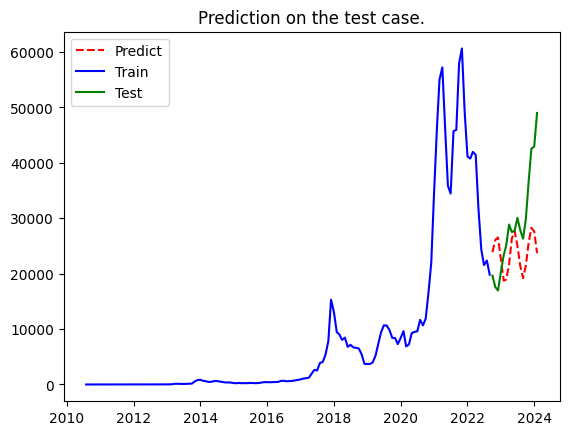

In [75]:
pred = model_testcase.predict(start = len(train_ori),end = len(df) -1)

# pred.dropna(inplace=True)
plt.plot(pred, color="red", label="Predict",linestyle='--')
plt.plot(train_ori, color = 'blue',label = 'Train')
plt.plot(test_ori, color="green", label="Test")
plt.legend(loc="best")
plt.title('Prediction on the test case.')
error = np.sqrt(mean_squared_error(test_ori,pred))
print(error)

# Step 8: Predict next 12 months

c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'ARIMA model forecasting next 12 months')

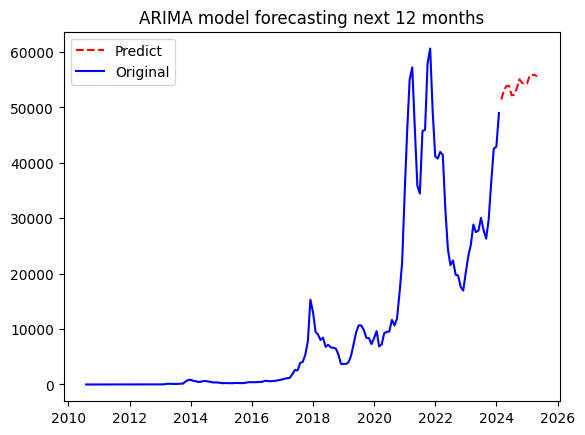

In [76]:
model_finalfull = ARIMA(df,order=(5,2,5)).fit()
prediii = model_finalfull.predict(start = len(df),end = len(df)+ 14)
plt.plot(prediii, color="r", label="Predict",linestyle='--')
plt.plot(df, color="b", label="Original")
plt.legend(loc='best')
plt.title("ARIMA model forecasting next 12 months")